In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from utils import plot, read_ucm_params_kalibr, initRectifyMap, equirectangular_projection, rotate_180

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 12]

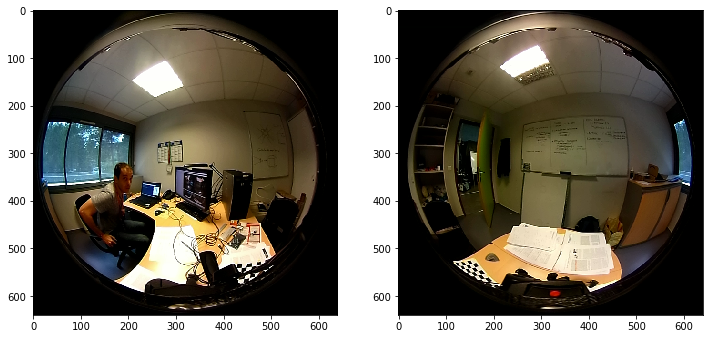

In [3]:
image_file = 'btm0005.png'
image = cv2.imread(image_file)
(rows,cols,channels) = image.shape
image_size = rows
btm_front_img = rotate_180(image[0:image_size, 0:image_size])
btm_back_img  = rotate_180(image[0:image_size, image_size:2*image_size])
plt.subplot(121); plot(btm_front_img);
plt.subplot(122); plot(btm_back_img);

#### Read parameters of bottom camera

In [4]:
params_file = '../../config/camchain-2019-06-11-14-36-07.yaml'
xi_bb, K_bb, D_bb = read_ucm_params_kalibr(params_file, 'cam0')
xi_bf, K_bf, D_bf = read_ucm_params_kalibr(params_file, 'cam1')

In [5]:
map1_bf, map2_bf = initRectifyMap(K_bf, D_bf, xi_bf)
map1_bb, map2_bb = initRectifyMap(K_bb, D_bb, xi_bb)

In [6]:
btm_front_eqimg = equirectangular_projection(btm_front_img, map1_bf, map2_bf)
btm_back_eqimg = equirectangular_projection(btm_back_img, map1_bb, map2_bb)
btm_both_eqimg = np.concatenate((btm_front_eqimg, btm_back_eqimg), axis=1)
btm_panorama = np.roll(btm_both_eqimg, 640, axis=1) # 320 + 320 (1/4 round)

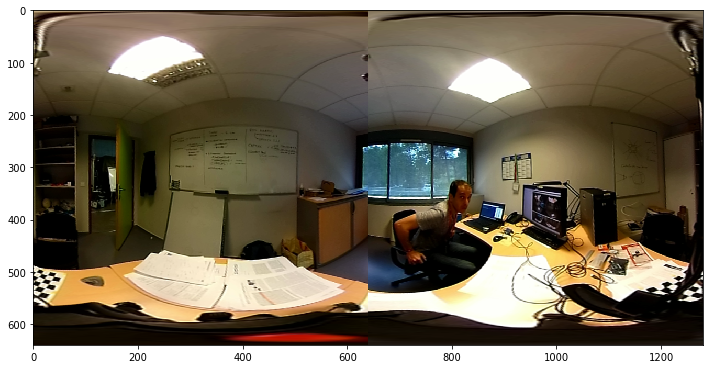

In [7]:
plot(btm_panorama);

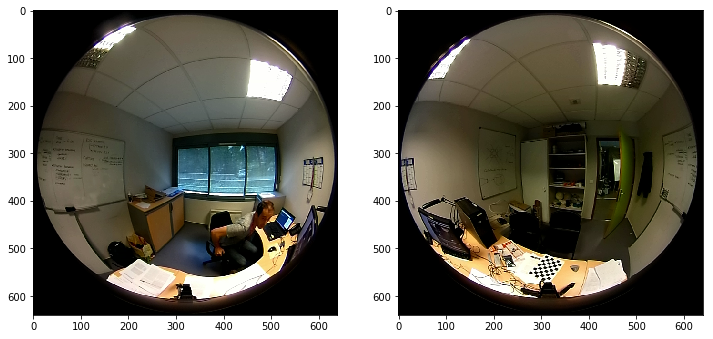

In [8]:
image_file = 'top0005.png'
image = cv2.imread(image_file)
(rows,cols,channels) = image.shape
image_size = rows
top_front_img = image[0:image_size, 0:image_size]
top_back_img  = image[0:image_size, image_size:2*image_size]
plt.subplot(121); plot(top_front_img);
plt.subplot(122); plot(top_back_img);

#### Read parameters of top camera

In [9]:
params_file = '../../config/camchain-2019-06-11-14-36-07.yaml'
xi_tb, K_tb, D_tb = read_ucm_params_kalibr(params_file, 'cam2')
xi_tf, K_tf, D_tf = read_ucm_params_kalibr(params_file, 'cam3')

In [10]:
map1_tf, map2_tf = initRectifyMap(K_tf, D_tf, xi_tf)
map1_tb, map2_tb = initRectifyMap(K_tb, D_tb, xi_tb)

In [11]:
top_front_eqimg = equirectangular_projection(top_front_img, map1_tf, map2_tf)
top_back_eqimg = equirectangular_projection(top_back_img, map1_tb, map2_tb)
top_both_eqimg = np.concatenate((top_front_eqimg, top_back_eqimg), axis=1)
top_panorama = np.roll(top_both_eqimg, 320, axis=1) # typically 320, modified for horizontal alignment

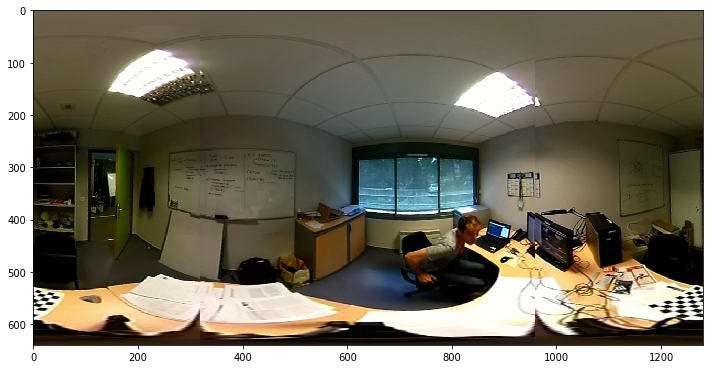

In [12]:
plot(top_panorama);

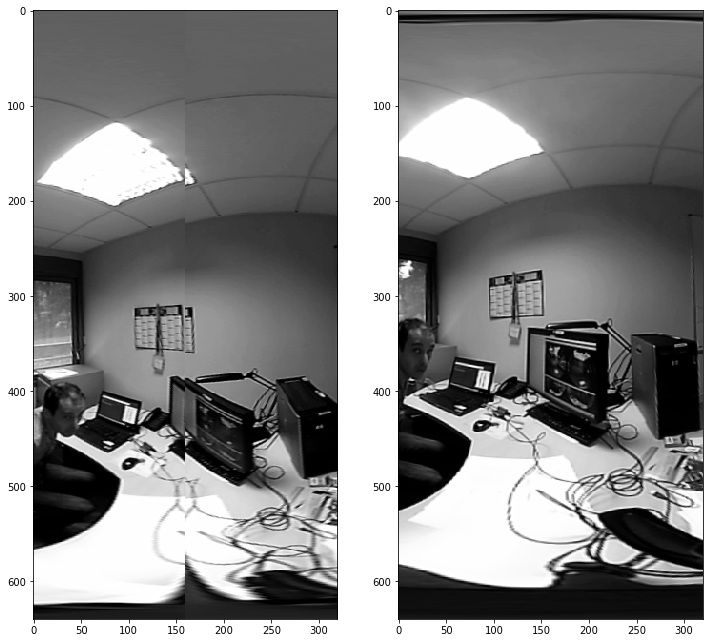

In [13]:
top_right_stitch = cv2.cvtColor(top_panorama[:,800:1120], cv2.COLOR_BGR2GRAY)
plt.subplot(121); plt.imshow(top_right_stitch, cmap='gray');
btm_right_stitch = cv2.cvtColor(btm_panorama[:,800:1120], cv2.COLOR_BGR2GRAY)
plt.subplot(122); plt.imshow(btm_right_stitch, cmap='gray');

In [14]:
%%time
orb = cv2.ORB_create()
kpt = orb.detect(top_right_stitch, None)
kpt, dest = orb.compute(top_right_stitch, kpt)
kpb = orb.detect(btm_right_stitch, None)
kpb, desb = orb.compute(btm_right_stitch, kpb)

CPU times: user 25.5 ms, sys: 4.55 ms, total: 30.1 ms
Wall time: 26.2 ms


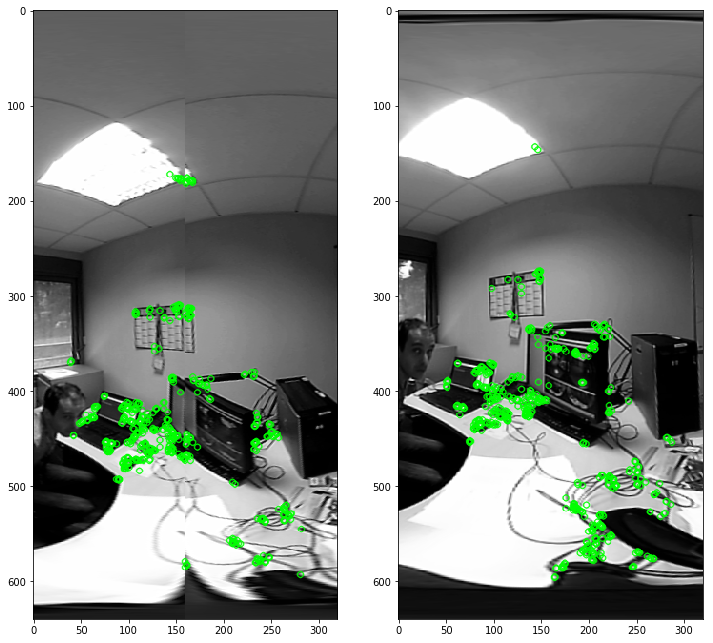

In [15]:
imgt = cv2.drawKeypoints(top_right_stitch, kpt, None, color=(0,255,0), flags=0)
imgb = cv2.drawKeypoints(btm_right_stitch, kpb, None, color=(0,255,0), flags=0)
plt.subplot(121); plt.imshow(imgt); plt.subplot(122); plt.imshow(imgb);

In [16]:
%%time
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(dest, desb)
good_matches = [m for m in matches if m.distance<50]
good_matches = sorted(good_matches, key = lambda x:x.distance)

CPU times: user 8.18 ms, sys: 5.53 ms, total: 13.7 ms
Wall time: 3.22 ms


In [17]:
min(matches, key = lambda x:x.distance).distance

11.0

In [18]:
max(matches, key = lambda x:x.distance).distance

87.0

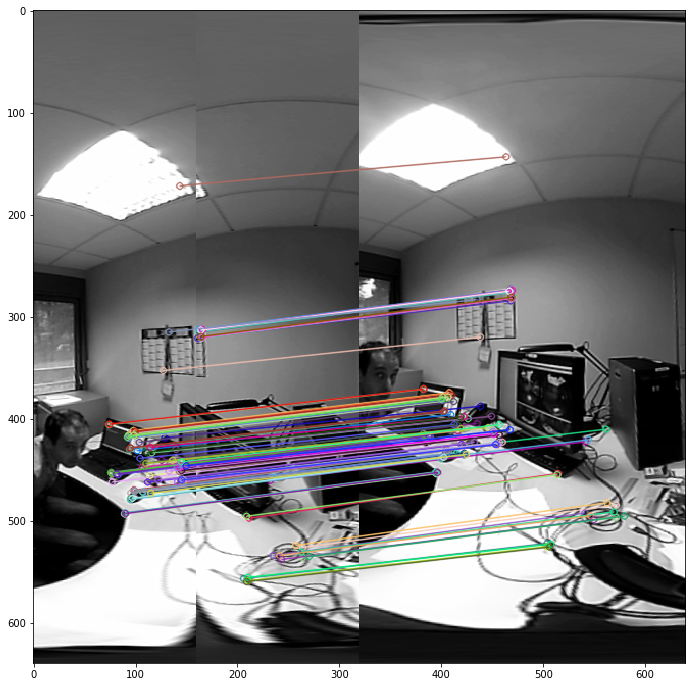

In [19]:
img3 = cv2.drawMatches(top_right_stitch, kpt, btm_right_stitch, kpb, good_matches, None, flags=2)
plt.imshow(img3);

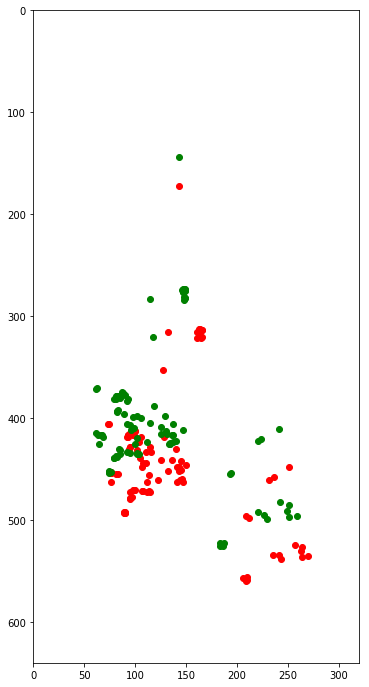

In [20]:
tpt = np.array([kpt[m.queryIdx].pt for m in good_matches])
bpt = np.array([kpb[m.trainIdx].pt for m in good_matches])
plt.scatter(tpt[:,0], tpt[:,1], c='red');
plt.scatter(bpt[:,0], bpt[:,1], c='green');
plt.axis('scaled'); plt.axis([0, 320, 0, 640]);  plt.gca().invert_yaxis();

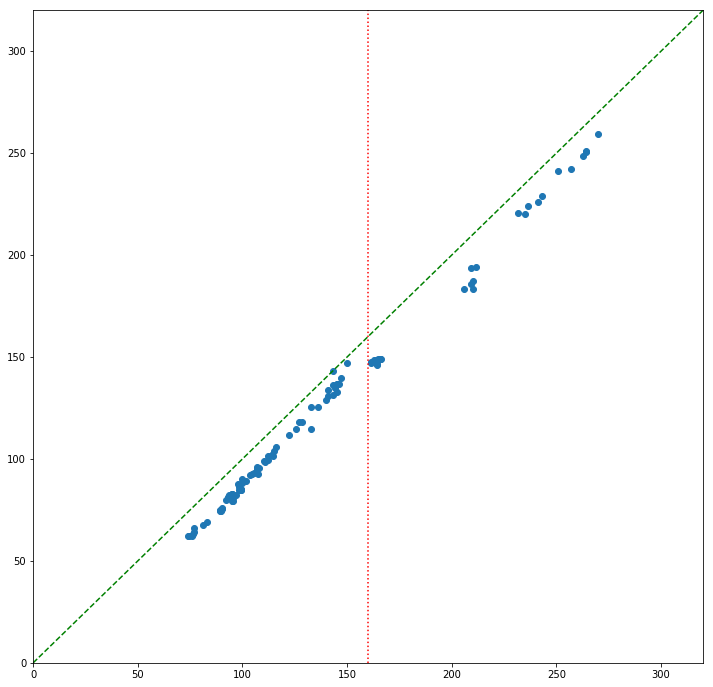

In [21]:
plt.scatter(tpt[:,0], bpt[:,0]);
plt.plot([160,160],[0,320],'r:');
plt.plot([0,320], [0,320], 'g--');
plt.axis([0,320,0,320]);

In [22]:
matplotlib.rcParams['figure.figsize'] = [12, 6]

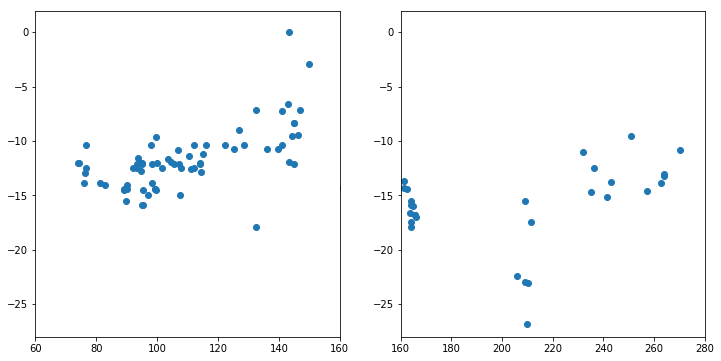

In [23]:
plt.subplot(121); plt.scatter(tpt[:,0], bpt[:,0] - tpt[:,0]);
plt.axis([60,160,-28,2]);

plt.subplot(122); plt.scatter(tpt[:,0], bpt[:,0] - tpt[:,0]);
plt.axis([160,280,-28,2]);